## Importing All Required Libraries

In [ ]:
pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. GOOGLE (GOOGL) Stock Price Dataset

In [ ]:
df = yf.download('GOOGL', start='2004-08-19', end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730975,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044


In [ ]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2024-11-19 00:00:00+00:00,178.119995,178.119995,178.869995,173.559998,173.720001,23434900
2024-11-20 00:00:00+00:00,175.979996,175.979996,177.679993,173.779999,177.339996,18997100
2024-11-21 00:00:00+00:00,167.630005,167.630005,174.130005,163.699997,173.899994,59734400
2024-11-22 00:00:00+00:00,164.759995,164.759995,166.460007,163.899994,165.850006,38560400
2024-11-25 00:00:00+00:00,166.640900,166.640900,168.629898,165.607193,166.089996,11779579


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.columns = df.columns.get_level_values(0)
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730975,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...,...
2024-11-19 00:00:00+00:00,178.119995,178.119995,178.869995,173.559998,173.720001,23434900
2024-11-20 00:00:00+00:00,175.979996,175.979996,177.679993,173.779999,177.339996,18997100
2024-11-21 00:00:00+00:00,167.630005,167.630005,174.130005,163.699997,173.899994,59734400


## Copying the dataset for future use

In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

### Dropping unwanted column

In [ ]:
df.drop(['Adj Close'], axis=1, inplace=True)

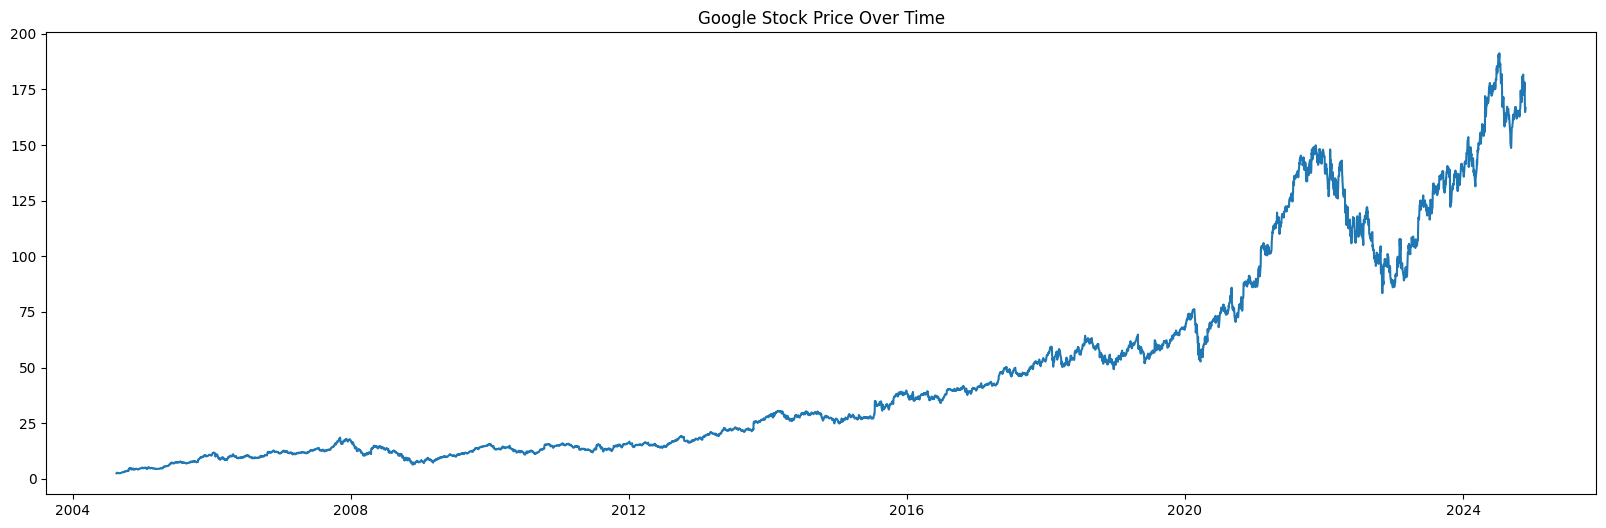

In [ ]:
# Visualize the close price
plt.figure(figsize=(20,6))
plt.plot(df['Close'])
plt.title('Google Stock Price Over Time')
plt.show()

### Check the data is stationary or not
## ADF test
We are using Augumented Dickey Fuller (ADF) test to eck if the price series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary. So if the p-value of the test is less than the significance level (0.05) than we can reject the null hypothesisband infer that the tim series is indeed stationary.

In [ ]:
# Perform ADF test
result = adfuller(df['Close'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'No. of lags used: {result[2]}')
print(f'Number of observations used: {result[3]}')

ADF Statistic: 1.3012522902459183
p-value: 0.9966159383973627
No. of lags used: 31
Number of observations used: 5071


### Auto-correlation function (ACF)

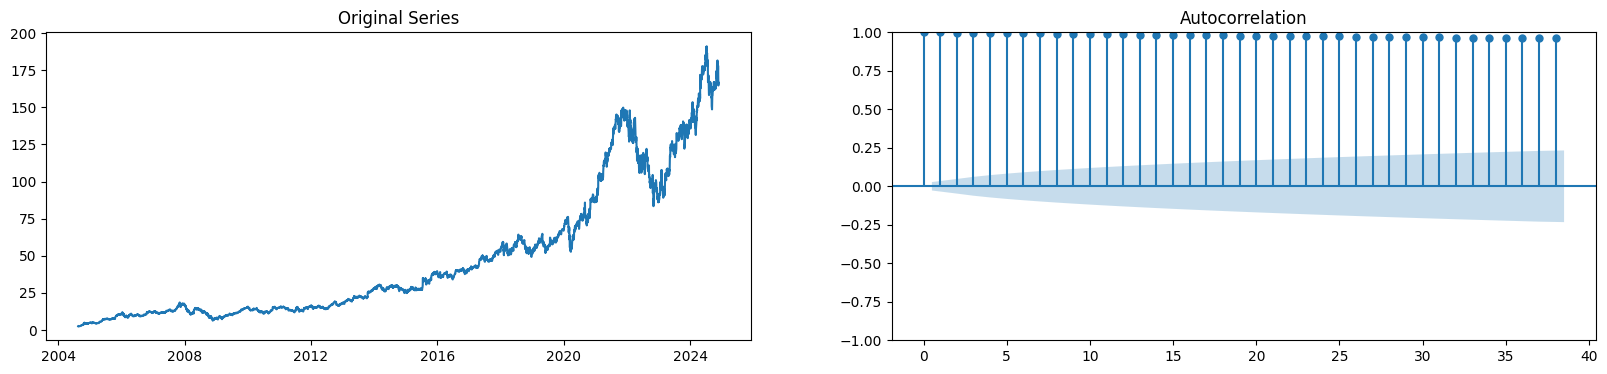

In [ ]:
# Plot ACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(df['Close'])
ax1.set_title('Original Series')

plot_acf(df['Close'], ax=ax2);

## d
### Differencing the Data (If Not Stationary)

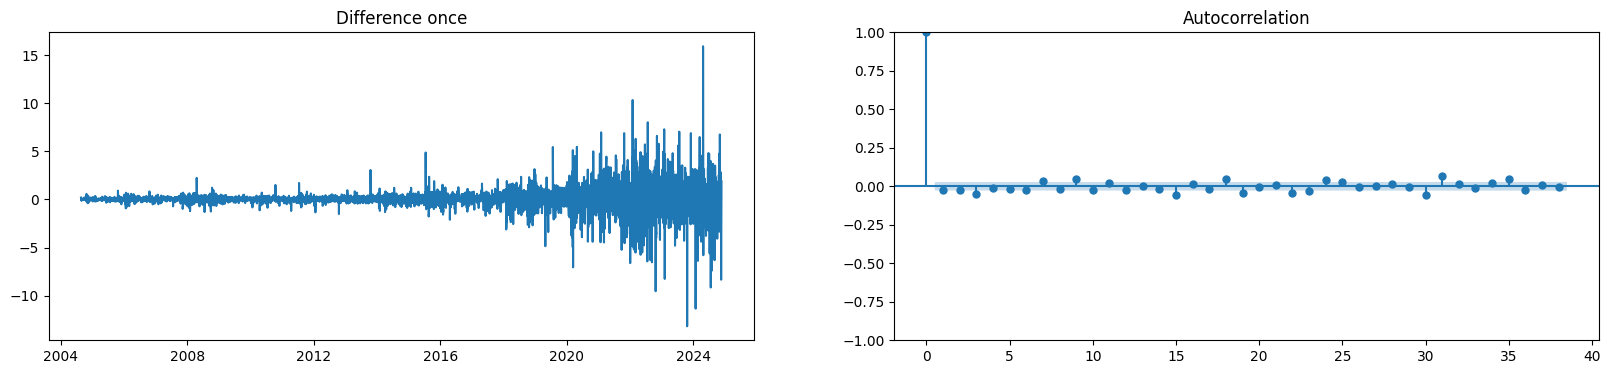

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')

plot_acf(diff, ax=ax2);

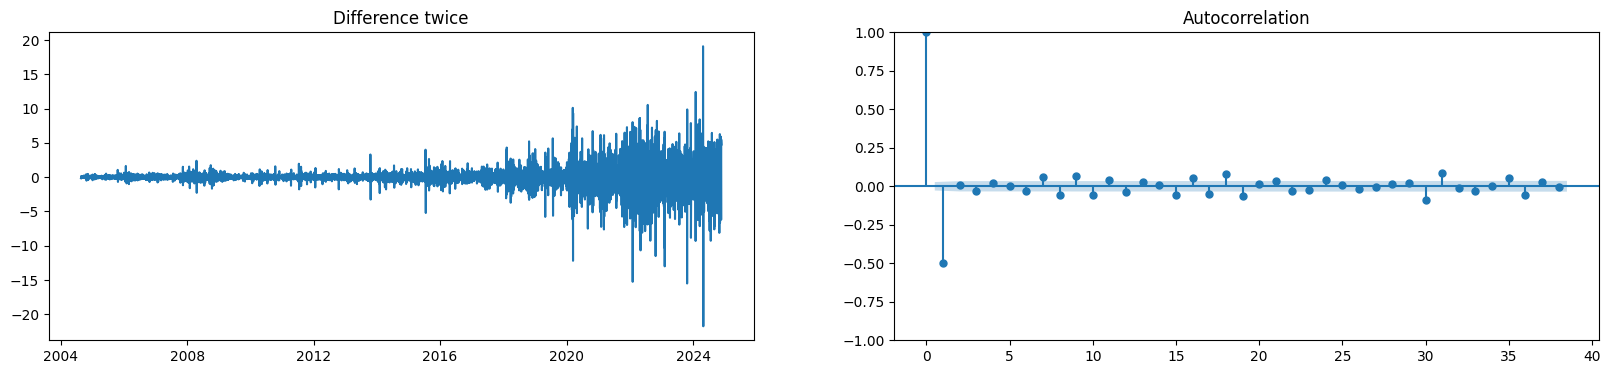

In [ ]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference twice')

plot_acf(diff, ax=ax2);

We can use the pmdarima library to get the number of differencing like d required for our model.

In [ ]:
ndiffs(df['Close'], test='adf')

1

## p
p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

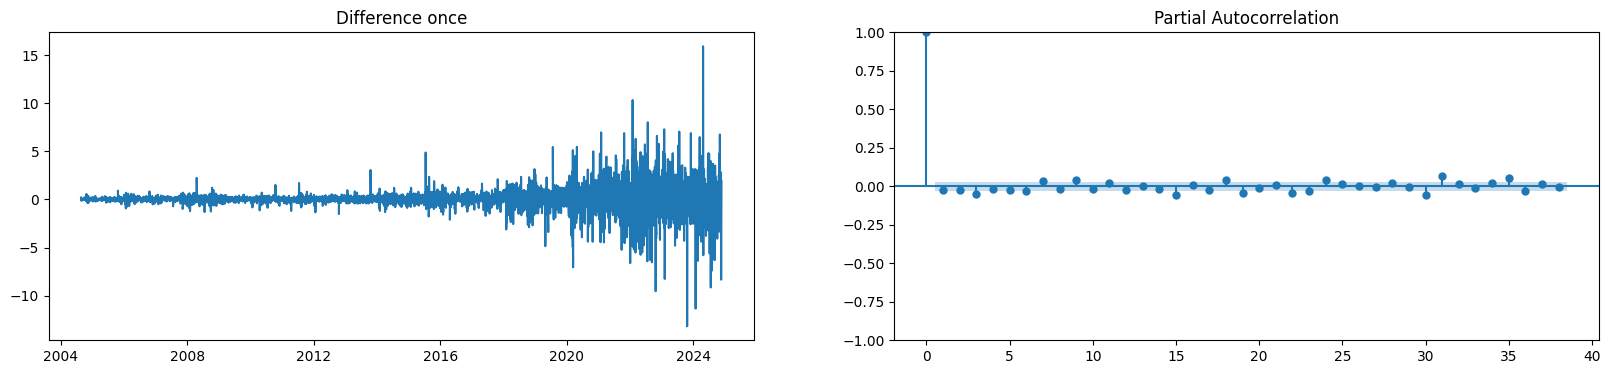

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

## q
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into ARIMA model.

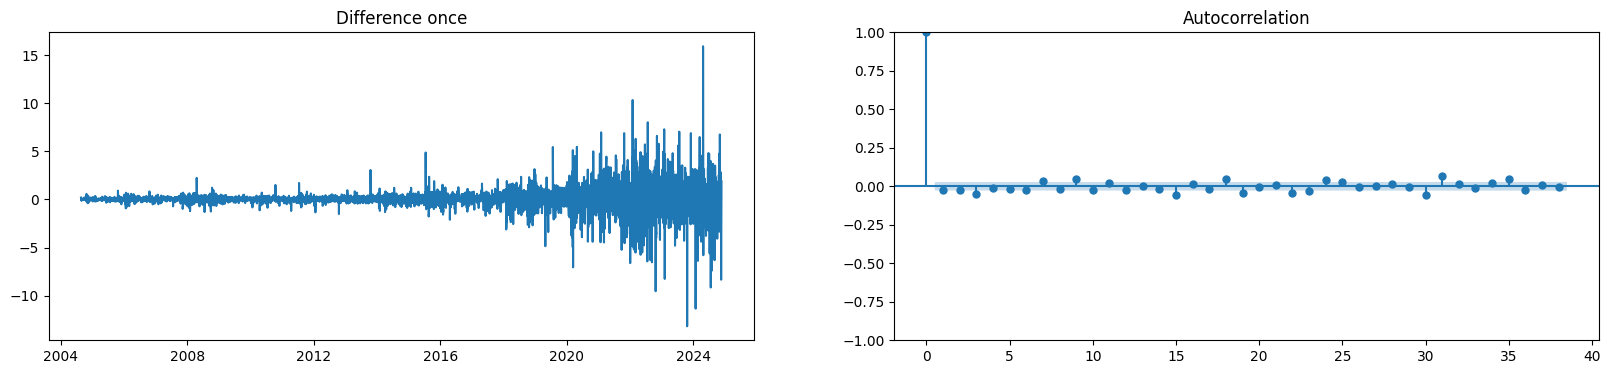

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

#Splitting the data into train set and test set

In [ ]:
y = df['Close']
X = df[['Open', 'High', 'Low', 'Volume']]

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.2, random_state=42)

### For p, d, q we can use the above method observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16258.798, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16258.277, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16258.135, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16260.525, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16245.370, Time=10.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16246.250, Time=9.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16246.353, Time=3.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16256.129, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16256.923, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16249.368, Time=6.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16248.942, Time=1.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 36.059 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:     

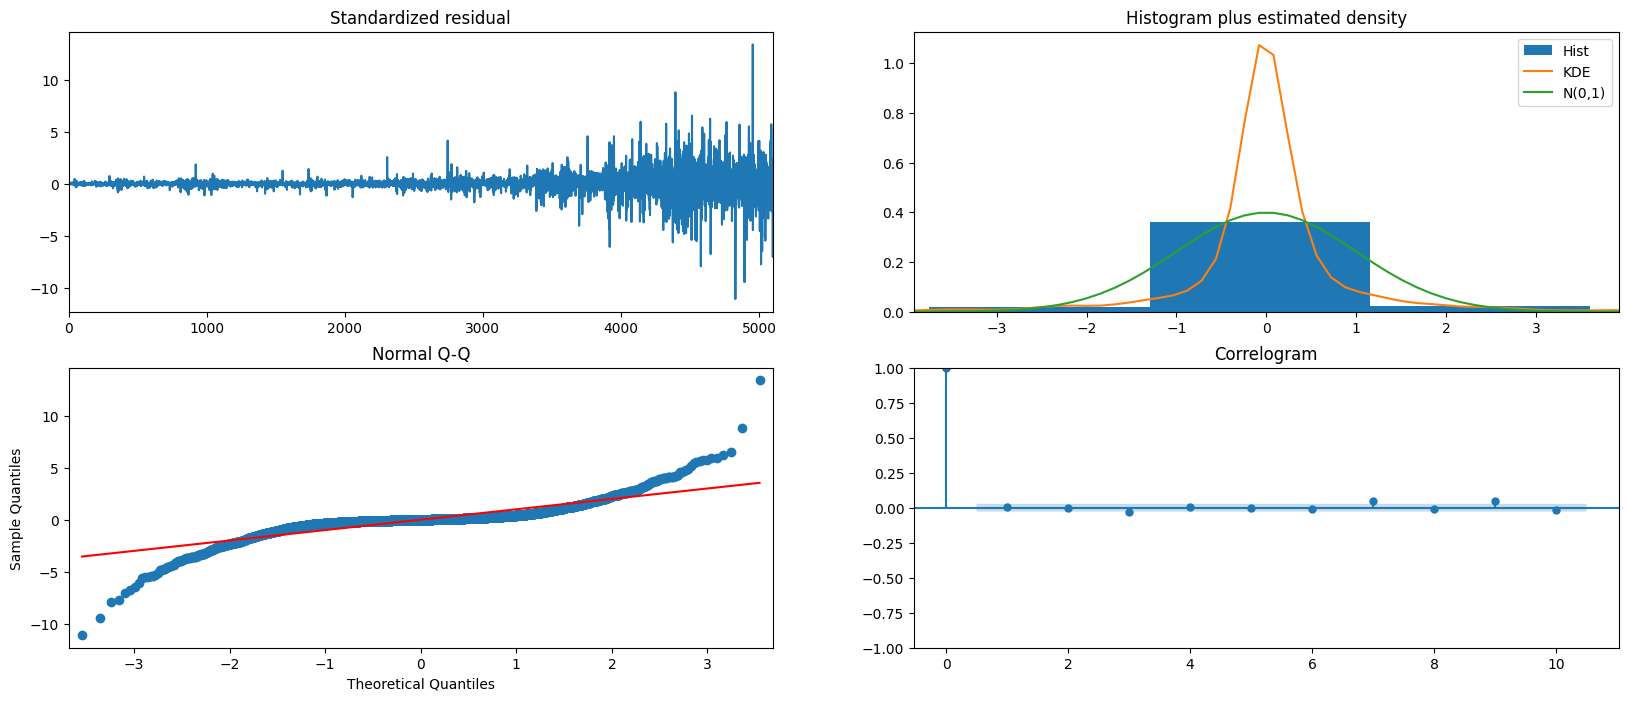

In [ ]:
model_autoARIMA = auto_arima(df.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(20,8))
plt.show()

### Now fitting the model

In [ ]:
model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=X_train)
start = time.time()
fitted_model = model.fit(disp=False)
end = time.time()
print('Training Time: ', end - start)

# Print model summary
print(fitted_model.summary())

Training Time:  30.90238857269287
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 4082
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3117.843
Date:                            Mon, 25 Nov 2024   AIC                           6253.686
Time:                                    17:42:26   BIC                           6310.486
Sample:                                         0   HQIC                          6273.803
                                           - 4082                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.5922   6.84e-05  -8659.413      0.000      -0.592      -0.592
H

In [ ]:
forecast = fitted_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Print forecasted values
forecast.index = y_test.index
forecast.sort_index(inplace=True)
forecast

,predicted_mean
Date,
2004-08-31 00:00:00+00:00,2.797601
2004-09-07 00:00:00+00:00,3.131128
2004-09-14 00:00:00+00:00,3.612478
2004-09-16 00:00:00+00:00,4.292580
2004-09-22 00:00:00+00:00,2.993956
...,...
2024-11-08 00:00:00+00:00,179.516611
2024-11-15 00:00:00+00:00,172.792900
2024-11-20 00:00:00+00:00,175.100305


In [ ]:
y_test.sort_index(inplace=True)
y_test

,Close
Date,
2004-08-31 00:00:00+00:00,2.561812
2004-09-07 00:00:00+00:00,2.542042
2004-09-14 00:00:00+00:00,2.790040
2004-09-16 00:00:00+00:00,2.852102
2004-09-22 00:00:00+00:00,2.962462
...,...
2024-11-08 00:00:00+00:00,178.350006
2024-11-15 00:00:00+00:00,172.490005
2024-11-20 00:00:00+00:00,175.979996


In [ ]:
y_train.sort_index(inplace=True)
y_train

,Close
Date,
2004-08-19 00:00:00+00:00,2.511011
2004-08-20 00:00:00+00:00,2.710460
2004-08-23 00:00:00+00:00,2.737738
2004-08-24 00:00:00+00:00,2.624374
2004-08-25 00:00:00+00:00,2.652653
...,...
2024-11-13 00:00:00+00:00,178.880005
2024-11-14 00:00:00+00:00,175.580002
2024-11-18 00:00:00+00:00,175.300003


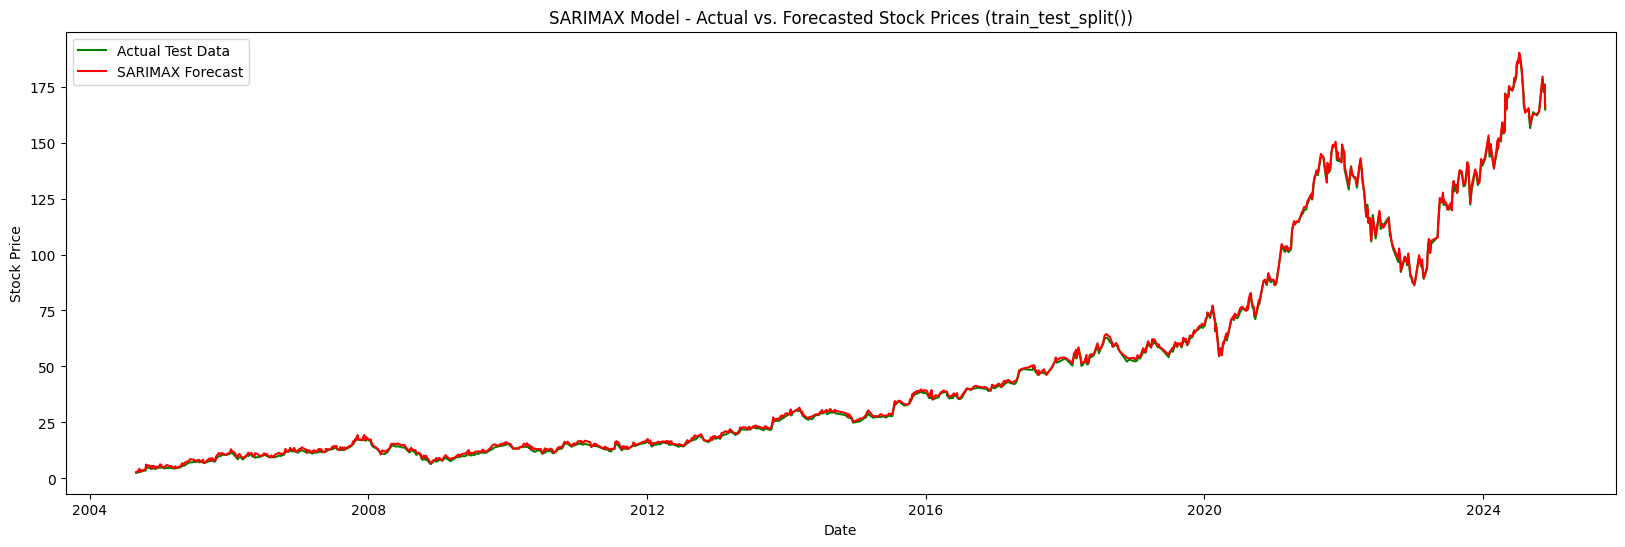

In [ ]:
# Plot the results
plt.figure(figsize=(20, 6))
# plt.plot(y_train, label='Train Data')
plt.plot(y_test, label='Actual Test Data', color='green')
plt.plot(y_test.index, forecast, label='SARIMAX Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('SARIMAX Model - Actual vs. Forecasted Stock Prices (train_test_split())')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.846573330595739
Root Mean Squared Error: 0.9200941965884466
Mean Absolute Error: 0.7687242218911938
